In [1]:
import gensim
import subprocess
import re
import numpy as np
import time
import nltk
import os
import json
import collections
import time
import matplotlib.pyplot as plt
import itertools
from gensim.utils import simple_preprocess
from sklearn.model_selection import train_test_split
from IPython.display import Image
from keras.utils.vis_utils import plot_model
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error
nltk.download('stopwords')
nltk.download('punkt')

Using TensorFlow backend.
/home/kirov/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/kirov/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/kirov/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/kirov/.local/lib/python3.7/site-packages/tensorflow/python/fra

True

### Problema: Determinar la veracidad de tweets, utilizando clasificación
- Implementar un clasificador de post de tweets para validar su veracidad.
- Para esto se utilizará redes neuronales y el árbol de  propagación de los tweets.


In [2]:
#Image("/home/eprovidel/Text_Mining/Proyecto/modelos.png")

In [3]:
import keras
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)
keras.backend.set_session(sess)

# Parte 1: Procesamiento de datos y funcionalidades

## Parte 1.1: Cargar tweets para generar datos de entrenamiento

In [4]:
words_not_in_model = list()
def computeDocumentAWE(docText, _model, _model_vocab, _emb_size):
    """
    Calcula el AWE del texto recibido en el parámetro docText.
    La variable docSum almacena la suma de los embeddings de cada
    palabra w en docText. Luego esta suma se divide por el total
    de n palabras consideradas.
    
    Se considero una palabra para el cálculo sólo si esta pertenece
    al vocabulario del modelo. Si no, no es considerada en la suma 
    ni tampoco en el calculo de n.
    """    
    docSum = np.zeros(_emb_size)
    n = 0
    
    ####
    ## AWE = 1/n * Sum w_embedding, para cada w en docText
    ####
    
    normalizedDocText = normalizarTexto(docText)
    
    for w in normalizedDocText:
        ## Se descartan palabras que no están en el modelo de embeddings (vocabulario)
        if w in _model_vocab:
            n = n + 1
            w_embedding = _model[w]
            docSum = docSum + w_embedding
        else:
            words_not_in_model.append(w)

    return docSum / n if n > 0 else docSum    

In [5]:
def normalizarTexto(docText):
    # En gensim.utils, pasa a minúsculas, descarta palabras muy grandes o muy pequeñas.
    return simple_preprocess(docText)

In [6]:
def parseTwitterTree(tree_file):
    tree_data = list()
    for line in tree_file:
        _, second_part = line.split('->')
        second_part = second_part.rstrip()
        second_part = second_part.replace("'", "\"")
        tree_data.append(json.loads(second_part))     
    return tree_data

In [7]:
def moses():
    p = subprocess.Popen("/home/kirov/dataset/script.sh", stdout=subprocess.PIPE, stderr=subprocess.PIPE, universal_newlines=True)
    stderr = p.communicate()
    p.wait()   

In [8]:
### Obtener diccionario con todos los posts
all_posts = {}
all_text = {}
for file in os.listdir('/home/kirov/dataset/post'):
    if file.endswith(".json"):        
        try:        
            with open(os.path.join('/home/kirov/dataset/post', file), 'r') as f:
                tweet_id  = os.path.splitext(file)[0]
                tweet_dic = json.load(f)
                #print(tweet_dic["text"])
                all_posts[tweet_id] = tweet_dic
                all_text[tweet_id] = tweet_dic["text"] # guarda todos los textos en un diccionario con tweet_id como key

        except:
            pass
        
### Pasa el diciconario a txt
keys_t = all_text.keys()

"""
with open('/home/kirov/dataset/text.txt', 'wb') as file:
    for k in keys_t:
        #elimina urls(opcional)
        all_text[k] = re.sub(r'''(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’]))''', " ", all_text[k])
        #elimina hashtags
        #all_text[k] = ' '.join(re.sub("(@[A-Za-z0–9]+)|([0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",all_text[k]).split())
        all_text[k] = ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",all_text[k]).split())
        #elimina menciones
        
        #elimina \n molestos
        all_text[k] = all_text[k].replace('\n', '')
        #elimina palabras compuestas con guion (wake-up)
        all_text[k] = all_text[k].replace('-',' ')
        #pasa el id con el texto
        #file.write((k + ":" + all_text[k]  + "\n").encode('utf8') )
        #pasa solo el texto
        file.write((all_text[k]  + "\n").encode('utf8') )
    else:
        print("Diccionario de textos creado")
"""

"""
### Llamar a funcion Moses

moses()

### Pasar txt a diccionario
"""

"""
with open('/home/kirov/dataset/textTrans.txt', 'r') as file:
        for file_line in file:
            id_l = file_line.split(":")[0]
            id_l = id_l.rstrip()
            text_pst = file_line.split(":")[1]
            all_posts[id_l]["text"] = text_pst
        else:
            print("Diccionario actualizado")
#ver como abrir dos archivos al mismo tiempo para añadir id al texto y actualizar diccionario
"""


"""
with open('/home/kirov/dataset/textTrans.txt', 'r') as file:
        count = -1
        b = [str(item) for item in keys_t]
        for file_line in file:
            #id_l = file_line.split(":")[0]
            #id_l = id_l.rstrip()
            #text_pst = file_line.split(":")[1]
            count = count +1
            id_l = b[count]
            file_line = file_line.rstrip()
            all_posts[id_l]["text"] = file_line
        else:
            print("Diccionario actualizado")
"""

"""
with open('/home/kirov/dataset/datosSinTraduccion.txt', 'wb') as file:
    for k in keys_t:
        file.write((all_text[k]  + "\n").encode('utf8') )
    else:
        print("Diccionario en ingles creado")
"""


### Obtener ids de tweets etiquetados
labels = {}
with open('/home/kirov/dataset/label.txt') as label_f:
    for label_line in label_f:
        
        label, tweet_id = label_line.split(':')
        tweet_id = tweet_id.rstrip()
        labels[tweet_id] = label

print("Tweets etiquetados      : ", len(labels))        

seqs_lens = []
labeled_posts = {}
number_of_tweets = 0
number_of_retweets = 0
number_of_invalid_tweets = 0
no_in_data = 0
for tweet_id in labels.keys():
    try:
        if tweet_id in all_posts:
            tree_path = os.path.join('/home/kirov/dataset/tree', tweet_id + '.txt')
            with open(tree_path) as tree_file:
                tree_data = parseTwitterTree(tree_file)
                ### Remover retweets                
                first = tree_data[0]
                without_rt = list(filter(lambda t: t[1] != tweet_id, tree_data))
                number_of_retweets = number_of_retweets + (len(tree_data) - len(without_rt))
                only_valid = list(filter(lambda t: t[1] in all_posts, without_rt))
                number_of_invalid_tweets = number_of_invalid_tweets + (len(without_rt) - len(only_valid))
                seqs_lens.append(len(only_valid))
                labeled_posts[tweet_id] = (labels[tweet_id], [first] + only_valid)
                number_of_tweets = number_of_tweets + 1 
        else:
             no_in_data = no_in_data + 1 
        
    except Exception as e:
        print(e) 
     
        
print("no_in_data              : ", no_in_data) ## están etiquetados, pero no en los post
print("number_of_tweets        : ", number_of_tweets)        
print("all_posts               : ", len(all_posts))
print("number_of_retweets      : ", number_of_retweets) ## En árbol de propagación
print("number_of_invalid_tweets: ", number_of_invalid_tweets) ## En árbol de propagación


Tweets etiquetados      :  818
no_in_data              :  65
number_of_tweets        :  753
all_posts               :  21741
number_of_retweets      :  297301
number_of_invalid_tweets:  6432


**Importante:** Importan sólo los datos etiquetados que se conocen y que no son retweets de cada árbol de progación.

## Parte 1.2: Aplicar AWE a cada tweet del arbol

In [9]:
## Cada palabra tiene un embedding que viene del modelo
## Se calcula AWE para cada post del árbol de propagación (lista de propagación que el primer elemento es el tweet original)
def computeTreeAWE(tree, _model, _model_vocab, _emb_size):
    return list(map(lambda t: [t[0], computeDocumentAWE(all_posts[t[1]]['text'],
                                                        _model, _model_vocab, _emb_size), t[2]], tree))

[17 19 33 23 28 32 22 22 22 22 16 17 15 18 22 15 19 16 21 11  9  8 10 14
  7  9  6  7  8  7 11  6  7  5  5 10  2  3  5  5  1  7  3  7  3  1  3  7
  4  5  2  3  5  1  1  4  1  4  5  0  3  0  1  4  2  3  4  2  1  2  1  1
  4  2  2  4  1  1  5  1  2  2  1  1  1  3  3  0  3  1  1  2  1  2  2  0
  1  1  1  1  0  0  1  0  1  1  0  1  2  1  1  0  0  1  0  1  0  1  0  0
  0  1  1  1  2  0  0  1  0  2  1  1  0  0  1  1  0  0  1  0  0  0  0  0
  1  0  1  0  1  0  0  0  0  0  1  1  0  0  2  1  0  0  1  1  1  0  0  0
  0  0  0  0  0  1  0  0  0  0  0  0  0  0  1  1  0  0  1  0  0  0  0  0
  0  0  0  0  1  1  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0
  0  0  0  0  0  0  0  0  1  0  0  0  1  1  0  0  1  0  0  0  0  0  0  1
  0  1  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0

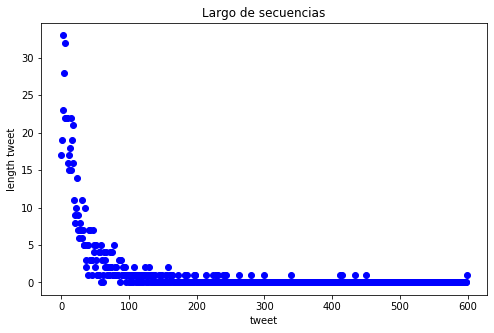

In [10]:
# Categorias: true, false, unverified, non-rumor
categories = ['true', 'false', 'unverified', 'non-rumor']
num_categories = len(categories)

#entrega un vector one-hot de la categoria, de largo 4 (por el número de categorias)
def to_category_vector(category):
    vector = np.zeros(len(categories)).astype(np.float32)
    
    for i in range(len(categories)):
        if categories[i] == category:
            vector[i] = 1.0
            break
    
    return vector

#La red neuronal necesita un tamaño fijo para la secuencia (datos de entrada)
#¿Que largo de secuencia utilizar?
counts = np.bincount(seqs_lens) ## seqs_len sólo de los 753
print(counts)
mode_seq_len = np.argmax(counts)
mean_seq_len = int(np.mean(seqs_lens))
min__seq_len = min(seqs_lens)
max__seq_len = max(seqs_lens) 
## luego se hace padding

print("seqs_lens   : ", seqs_lens)
print("min__seq_len: ", min__seq_len)
print("max__seq_len: ", max__seq_len)
print("mean_seq_len: ", mean_seq_len)
print("mode_seq_len: ", mode_seq_len )

plt.close('all')
plt.figure(figsize=(8,5))
plt.plot(counts,'bo')
plt.title("Largo de secuencias")
plt.xlabel("tweet")
plt.ylabel("length tweet")
plt.savefig('/home/kirov/plots/LSTMTrans/plt_largoSecuencias')

tree_max_num_seq = mean_seq_len

In [11]:
## padding al final, con empty
def padAWE(empty, max_num, seq):
    from itertools import repeat
    seq.extend(repeat(empty, max_num - len(seq)))
    return seq

In [12]:
## 
def generate_w2v_variant(_model, _model_vocab, _emb_size):
    
    empty_awe = np.zeros(_emb_size)
    ## Calcula AWE de cada árbol
    labeled_posts_awe = { k: (v[0], computeTreeAWE(v[1], _model, _model_vocab, _emb_size)) for k, v in labeled_posts.items() }
    ## Realiza padding a las secuencias
    padded_labeled_posts_awe = {k: (v[0], padAWE(empty_awe, tree_max_num_seq, v[1])) for k, v in labeled_posts_awe.items()}

    #Genera los datos X e Y para alimentar el modelo de red neuronal
    #Inicialmente con ceros y con la forma adecuada.
    X = np.zeros(shape=(number_of_tweets, tree_max_num_seq, _emb_size)).astype(np.float32)
    Y = np.zeros(shape=(number_of_tweets, num_categories)).astype(np.float32)

    # Asigna al vector X los datos correspondientes
    for idx, (tweet_id, tweet_data) in enumerate(list(padded_labeled_posts_awe.items())):
        for jdx, tweet_d in enumerate(tweet_data[1]):
            ### tweet_d = [uid, tweet_awe, time]
            if jdx == tree_max_num_seq:
                break            
            else:            
                X[idx, jdx, :] = tweet_d[1]

    # Asigna al vector Y los datos correspondientes            
    for idx, (tweet_id, tweet_data) in enumerate(list(padded_labeled_posts_awe.items())):
        Y[idx, :] = to_category_vector(tweet_data[0])

    print(np.shape(X))
    print(np.shape(Y))
    return X, Y

## Parte 1.3: Modelo LSTM

In [13]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, LSTM, GRU


### tensorflow OMP: Error #15
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

def create_model_LSTM(emb_size, units = 200):
    model = Sequential()
    model.add(LSTM(units, input_shape=(tree_max_num_seq, emb_size),return_sequences=False))
    model.add(Dropout(0.3))
    model.add(Dense(num_categories))
    model.add(Activation('softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])    
    return model



## Parte 1.4: Funciones para graficar

In [14]:
def graphic_data(dataX, dataY, labels, title, x_label, y_label, x_min, y_min, x_max, y_max=0):
    plt.close('all') 
    plt.title(title)
    for d in dataY:
        plt.ylim(y_min,y_max)
        plt.xlim(x_min,x_max)
        plt.plot(d)
        plt.xlabel(x_label)
        plt.ylabel(y_label)
        plt.xticks(dataX)
    plt.legend(labels, loc='upper right')
    plt.savefig('/home/kirov/plots/LSTMTrans/plt_grapicData')
    plt.show()

In [15]:
#ref: https://scikit-learn.org/stable/auto_examples/model_selection/plot_cv_indices.html#sphx-glr-auto-examples-model-selection-plot-cv-indices-py
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(6,6))
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.savefig('/home/kirov/plots/LSTMTrans/plt_matrizLTSM')

In [16]:
def plot_conf_matrix(y_true, y_pred, _title):
    y_t = y_true.argmax(1)#Yw2v50_full.argmax(1)
    y_p = y_pred.argmax(1)#Yw2v50_predict.argmax(1)
    conf_matrix = confusion_matrix(y_t, y_p)
    class_names = ['true', 'false', 'unverified', 'non-rumor']
    # Plot confusion matrix
    plt.figure(figsize=(5,5))
    plot_confusion_matrix(conf_matrix, classes=class_names, normalize=False,
                      title=_title,cmap=plt.cm.Greens) 

## Parte 1.5: Entrenamiento y Pruebas

In [17]:
epochs = 50 #200
units_final = [128,256] #[8,16, 32, 64, 128, 256, 512, 1024]

In [18]:
dummy_model = create_model_LSTM(10, 128)
dummy_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128)               71168     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 516       
_________________________________________________________________
activation_1 (Activation)    (None, 4)                 0         
Total params: 71,684
Trainable params: 71,684
Non-trainable params: 0
_________________________________________________________________


In [19]:
def perform_kfold_validation(X, Y, _emb_size, k = 5, _verbose = 0):
    seed = 7
    results_score = []
    results_acc   = []
    results_time  = []
    kfold = StratifiedKFold(n_splits=k, shuffle=True, random_state=seed)
    y_pred = []

    for j, (train_idx, test_idx) in enumerate(kfold.split(X, Y.argmax(1))):
        print('\nFold ',j)
        print("\nlen train index: %s" % len(train_idx))       
        print("len test index: %s" % len(test_idx))
        X_train_cv = X[train_idx]
        Y_train_cv = Y[train_idx]
        X_test_cv  = X[test_idx]
        Y_test_cv  = Y[test_idx]

        model = create_model_LSTM(_emb_size) ## creamos modelo 

        start_time = time.time()
        model.fit(X_train_cv, Y_train_cv, batch_size=128, epochs=200, verbose= _verbose)     ## entrenamos
        score, acc = model.evaluate(X_test_cv, Y_test_cv, batch_size=128,verbose= _verbose) ## evaluamos /acc: accuracy
        end_time = time.time()

        print('Score: %1.4f' % score)
        print('Accuracy: %1.4f' % acc)  
        print('time: %1.4f' % (end_time - start_time))
        results_score.append(score)
        results_acc.append(acc)
        results_time.append((end_time - start_time))
    
    return results_score, results_acc, results_time

In [20]:
### https://datascience.stackexchange.com/questions/20413/clarification-on-the-keras-recurrent-unit-cell
def perform_final_validation(X, Y, X_validate, Y_validate, _emb_size, units=[8,16, 32, 64, 128, 200], _epochs=200, _verbose=1):
    h_units_score = []
    h_units_acc   = []
    history = []
    all_models = []
    for unit_size in (units): #[8,16, 32, 64, 128, 200, 512, 1024]
        print("########################")
        print("## UNIT SIZE ", unit_size)

        final_model = create_model_LSTM(_emb_size, units = unit_size)
        

        
        final_model.summary()
        
        history.append(final_model.fit(X, Y, batch_size=128, epochs=_epochs, verbose=_verbose))
        score, acc = final_model.evaluate(X_validate, Y_validate, batch_size=128)
        h_units_score.append(score)
        h_units_acc.append(acc)
        all_models.append(final_model)
    return h_units_score, h_units_acc,history, all_models

## Parte 2: Modelo LSTM

### Modelo word2vec específico, LSTM

### Creando los vectores
Se utilizan todos los tweets etiquetados como el universo de documentos, para crear el modelo de embedding w2v

In [21]:
# build vocabulary and train model
w2v50_emb_size = 50
WINDOW = 5
W2V_EPOCHS = 50
BATCH_SIZE = 128

documents = []
for k, v in labeled_posts.items():
    for t in v[1]:
        #print(t[1]) ## sera porque algunos text estan vacios????
        # Dejar todo en lowercase
        documents.append(simple_preprocess(all_posts[t[1]]['text']))

In [22]:

w2v50_model = gensim.models.word2vec.Word2Vec(
 documents,
 size=w2v50_emb_size,
 window=WINDOW,
 min_count=2,
 workers=4,
 iter=W2V_EPOCHS
)

#Train model
w2v50_model.train(documents, total_examples=len(documents), epochs=w2v50_model.epochs)

(14800308, 18536800)

In [23]:
w2v50_model_vocab = w2v50_model.wv.vocab

In [24]:
Xw2v50_full, Yw2v50_full = generate_w2v_variant(w2v50_model, w2v50_model_vocab, w2v50_emb_size)
Xw2v50, X_1w2v50, Yw2v50, Y_1w2v50 = train_test_split(Xw2v50_full, Yw2v50_full, test_size=0.15)
perform_kfold_validation(Xw2v50, Yw2v50, w2v50_emb_size)
#perform_final_validation(Xw2v50, Yw2v50, X_1, Y_1, w2v50_emb_size) #X_1 y Y_1 Es el tamaño del set de testing
perform_final_validation(Xw2v50, Yw2v50, X_1w2v50, Y_1w2v50, w2v50_emb_size)

/home/kirov/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


(753, 36, 50)
(753, 4)

Fold  0

len train index: 512
len test index: 128

Score: 2.7109
Accuracy: 0.7266
time: 162.5706

Fold  1

len train index: 512
len test index: 128
Score: 1.8397
Accuracy: 0.7656
time: 177.8727

Fold  2

len train index: 512
len test index: 128
Score: 2.8308
Accuracy: 0.7031
time: 161.7404

Fold  3

len train index: 512
len test index: 128
Score: 2.6174
Accuracy: 0.7266
time: 180.8045

Fold  4

len train index: 512
len test index: 128
Score: 2.9239
Accuracy: 0.6953
time: 171.6919
########################
## UNIT SIZE  8
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 8)                 1888      
_________________________________________________________________
dropout_7 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_7 (Dense)              (No

640/640 [==============================] - 0s 284us/step - loss: 0.9531 - accuracy: 0.6062
Epoch 65/200
640/640 [==============================] - 0s 208us/step - loss: 0.9481 - accuracy: 0.5859
Epoch 66/200
640/640 [==============================] - 0s 207us/step - loss: 0.9453 - accuracy: 0.6062
Epoch 67/200
640/640 [==============================] - 0s 202us/step - loss: 0.9402 - accuracy: 0.5828
Epoch 68/200
640/640 [==============================] - 0s 200us/step - loss: 0.9383 - accuracy: 0.6109
Epoch 69/200
640/640 [==============================] - 0s 211us/step - loss: 0.9359 - accuracy: 0.6062
Epoch 70/200
640/640 [==============================] - 0s 224us/step - loss: 0.9062 - accuracy: 0.6328
Epoch 71/200
640/640 [==============================] - 0s 212us/step - loss: 0.9167 - accuracy: 0.6422
Epoch 72/200
640/640 [==============================] - 0s 186us/step - loss: 0.9198 - accuracy: 0.6219
Epoch 73/200
640/640 [==============================] - 0s 194us/step - loss:

640/640 [==============================] - 0s 260us/step - loss: 0.6225 - accuracy: 0.7953
Epoch 143/200
640/640 [==============================] - 0s 254us/step - loss: 0.6335 - accuracy: 0.7563
Epoch 144/200
640/640 [==============================] - 0s 272us/step - loss: 0.6470 - accuracy: 0.7656
Epoch 145/200
640/640 [==============================] - 0s 424us/step - loss: 0.6205 - accuracy: 0.7937
Epoch 146/200
640/640 [==============================] - 0s 181us/step - loss: 0.6544 - accuracy: 0.7563
Epoch 147/200
640/640 [==============================] - 0s 197us/step - loss: 0.6287 - accuracy: 0.7781
Epoch 148/200
640/640 [==============================] - 0s 185us/step - loss: 0.6446 - accuracy: 0.7750
Epoch 149/200
640/640 [==============================] - 0s 307us/step - loss: 0.6213 - accuracy: 0.7781
Epoch 150/200
640/640 [==============================] - 0s 181us/step - loss: 0.6280 - accuracy: 0.7812
Epoch 151/200
640/640 [==============================] - 0s 186us/ste

640/640 [==============================] - 0s 337us/step - loss: 1.2937 - accuracy: 0.3969
Epoch 12/200
640/640 [==============================] - 0s 336us/step - loss: 1.2851 - accuracy: 0.4000
Epoch 13/200
640/640 [==============================] - 0s 329us/step - loss: 1.2617 - accuracy: 0.4266
Epoch 14/200
640/640 [==============================] - 0s 359us/step - loss: 1.2495 - accuracy: 0.4313
Epoch 15/200
640/640 [==============================] - 0s 253us/step - loss: 1.2355 - accuracy: 0.4469
Epoch 16/200
640/640 [==============================] - 0s 390us/step - loss: 1.2237 - accuracy: 0.4422
Epoch 17/200
640/640 [==============================] - 0s 407us/step - loss: 1.1875 - accuracy: 0.4922
Epoch 18/200
640/640 [==============================] - 0s 337us/step - loss: 1.1687 - accuracy: 0.5094
Epoch 19/200
640/640 [==============================] - 0s 401us/step - loss: 1.1303 - accuracy: 0.5297
Epoch 20/200
640/640 [==============================] - 0s 373us/step - loss:

Epoch 90/200
640/640 [==============================] - 0s 356us/step - loss: 0.3024 - accuracy: 0.9203
Epoch 91/200
640/640 [==============================] - 0s 313us/step - loss: 0.3226 - accuracy: 0.9031
Epoch 92/200
640/640 [==============================] - 0s 419us/step - loss: 0.3346 - accuracy: 0.9062
Epoch 93/200
640/640 [==============================] - 0s 228us/step - loss: 0.3119 - accuracy: 0.9109
Epoch 94/200
640/640 [==============================] - 0s 365us/step - loss: 0.3008 - accuracy: 0.9266
Epoch 95/200
640/640 [==============================] - 0s 364us/step - loss: 0.3073 - accuracy: 0.9234
Epoch 96/200
640/640 [==============================] - 0s 476us/step - loss: 0.3044 - accuracy: 0.9156
Epoch 97/200
640/640 [==============================] - 0s 549us/step - loss: 0.3022 - accuracy: 0.9234
Epoch 98/200
640/640 [==============================] - 0s 588us/step - loss: 0.2938 - accuracy: 0.9172
Epoch 99/200
640/640 [==============================] - 0s 617us

640/640 [==============================] - 0s 305us/step - loss: 0.2130 - accuracy: 0.9547
Epoch 169/200
640/640 [==============================] - 0s 308us/step - loss: 0.2011 - accuracy: 0.9578
Epoch 170/200
640/640 [==============================] - 0s 234us/step - loss: 0.2021 - accuracy: 0.9594
Epoch 171/200
640/640 [==============================] - 0s 317us/step - loss: 0.2152 - accuracy: 0.9531
Epoch 172/200
640/640 [==============================] - 0s 240us/step - loss: 0.2158 - accuracy: 0.9594
Epoch 173/200
640/640 [==============================] - 0s 261us/step - loss: 0.2001 - accuracy: 0.9531
Epoch 174/200
640/640 [==============================] - 0s 288us/step - loss: 0.2137 - accuracy: 0.9578
Epoch 175/200
640/640 [==============================] - 0s 377us/step - loss: 0.2209 - accuracy: 0.9547
Epoch 176/200
640/640 [==============================] - 0s 301us/step - loss: 0.2067 - accuracy: 0.9594
Epoch 177/200
640/640 [==============================] - 0s 340us/ste

640/640 [==============================] - 0s 546us/step - loss: 0.4576 - accuracy: 0.8813
Epoch 38/200
640/640 [==============================] - 0s 431us/step - loss: 0.4324 - accuracy: 0.8719
Epoch 39/200
640/640 [==============================] - 0s 417us/step - loss: 0.4152 - accuracy: 0.8859
Epoch 40/200
640/640 [==============================] - 0s 617us/step - loss: 0.4117 - accuracy: 0.8828
Epoch 41/200
640/640 [==============================] - 0s 420us/step - loss: 0.3891 - accuracy: 0.8938
Epoch 42/200
640/640 [==============================] - 0s 470us/step - loss: 0.3814 - accuracy: 0.8938
Epoch 43/200
640/640 [==============================] - 0s 423us/step - loss: 0.3801 - accuracy: 0.8984
Epoch 44/200
640/640 [==============================] - 0s 411us/step - loss: 0.3746 - accuracy: 0.8984
Epoch 45/200
640/640 [==============================] - 0s 579us/step - loss: 0.3501 - accuracy: 0.9062
Epoch 46/200
640/640 [==============================] - 0s 440us/step - loss:

640/640 [==============================] - 0s 385us/step - loss: 0.1090 - accuracy: 0.9797
Epoch 116/200
640/640 [==============================] - 0s 403us/step - loss: 0.0999 - accuracy: 0.9828
Epoch 117/200
640/640 [==============================] - 0s 277us/step - loss: 0.1066 - accuracy: 0.9828
Epoch 118/200
640/640 [==============================] - 0s 331us/step - loss: 0.1023 - accuracy: 0.9812
Epoch 119/200
640/640 [==============================] - 0s 378us/step - loss: 0.0949 - accuracy: 0.9812
Epoch 120/200
640/640 [==============================] - 0s 417us/step - loss: 0.1011 - accuracy: 0.9812
Epoch 121/200
640/640 [==============================] - 0s 413us/step - loss: 0.0993 - accuracy: 0.9828
Epoch 122/200
640/640 [==============================] - 0s 352us/step - loss: 0.1032 - accuracy: 0.9797
Epoch 123/200
640/640 [==============================] - 0s 348us/step - loss: 0.0999 - accuracy: 0.9828
Epoch 124/200
640/640 [==============================] - 0s 422us/ste

640/640 [==============================] - 0s 368us/step - loss: 0.1050 - accuracy: 0.9781
Epoch 194/200
640/640 [==============================] - 0s 254us/step - loss: 0.1141 - accuracy: 0.9766
Epoch 195/200
640/640 [==============================] - 0s 279us/step - loss: 0.0913 - accuracy: 0.9766
Epoch 196/200
640/640 [==============================] - 0s 284us/step - loss: 0.1132 - accuracy: 0.9750
Epoch 197/200
640/640 [==============================] - 0s 396us/step - loss: 0.1469 - accuracy: 0.9625
Epoch 198/200
640/640 [==============================] - 0s 392us/step - loss: 0.1711 - accuracy: 0.9531
Epoch 199/200
640/640 [==============================] - 0s 328us/step - loss: 0.1091 - accuracy: 0.9719
Epoch 200/200
113/113 [==============================] - 0s 3ms/step
########################
## UNIT SIZE  64
Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM

640/640 [==============================] - 0s 580us/step - loss: 0.0840 - accuracy: 0.9828
Epoch 63/200
640/640 [==============================] - 0s 625us/step - loss: 0.0953 - accuracy: 0.9703
Epoch 64/200
640/640 [==============================] - 0s 532us/step - loss: 0.0728 - accuracy: 0.9812
Epoch 65/200
640/640 [==============================] - 0s 600us/step - loss: 0.0604 - accuracy: 0.9859
Epoch 66/200
640/640 [==============================] - 0s 597us/step - loss: 0.0696 - accuracy: 0.9844
Epoch 67/200
640/640 [==============================] - 0s 559us/step - loss: 0.0601 - accuracy: 0.9859
Epoch 68/200
640/640 [==============================] - 0s 549us/step - loss: 0.0547 - accuracy: 0.9875
Epoch 69/200
640/640 [==============================] - 0s 540us/step - loss: 0.0583 - accuracy: 0.9875
Epoch 70/200
640/640 [==============================] - 0s 460us/step - loss: 0.0529 - accuracy: 0.9859
Epoch 71/200
640/640 [==============================] - 0s 526us/step - loss:

640/640 [==============================] - 0s 767us/step - loss: 0.0238 - accuracy: 0.9969
Epoch 141/200
640/640 [==============================] - 0s 412us/step - loss: 0.0240 - accuracy: 0.9969
Epoch 142/200
640/640 [==============================] - 0s 514us/step - loss: 0.0255 - accuracy: 0.9953
Epoch 143/200
640/640 [==============================] - 0s 497us/step - loss: 0.0225 - accuracy: 0.9969
Epoch 144/200
640/640 [==============================] - 0s 456us/step - loss: 0.0243 - accuracy: 0.9969
Epoch 145/200
640/640 [==============================] - 0s 526us/step - loss: 0.0239 - accuracy: 0.9969
Epoch 146/200
640/640 [==============================] - 0s 456us/step - loss: 0.0223 - accuracy: 0.9969
Epoch 147/200
640/640 [==============================] - 0s 454us/step - loss: 0.0220 - accuracy: 0.9969
Epoch 148/200
640/640 [==============================] - 0s 440us/step - loss: 0.0204 - accuracy: 0.9969
Epoch 149/200
640/640 [==============================] - 0s 453us/ste

640/640 [==============================] - 1s 842us/step - loss: 0.6660 - accuracy: 0.7328
Epoch 10/200
640/640 [==============================] - 1s 836us/step - loss: 0.6114 - accuracy: 0.7516
Epoch 11/200
640/640 [==============================] - 1s 910us/step - loss: 0.5657 - accuracy: 0.7703
Epoch 12/200
640/640 [==============================] - 1s 790us/step - loss: 0.4930 - accuracy: 0.8156
Epoch 13/200
640/640 [==============================] - 1s 795us/step - loss: 0.4673 - accuracy: 0.8172
Epoch 14/200
640/640 [==============================] - 1s 893us/step - loss: 0.4951 - accuracy: 0.8109
Epoch 15/200
640/640 [==============================] - 1s 906us/step - loss: 0.3831 - accuracy: 0.8734
Epoch 16/200
640/640 [==============================] - 1s 860us/step - loss: 0.3491 - accuracy: 0.8828
Epoch 17/200
640/640 [==============================] - 1s 965us/step - loss: 0.3104 - accuracy: 0.9016
Epoch 18/200
640/640 [==============================] - 0s 774us/step - loss:

640/640 [==============================] - 1s 866us/step - loss: 0.0168 - accuracy: 0.9953
Epoch 89/200
640/640 [==============================] - 1s 914us/step - loss: 0.0190 - accuracy: 0.9937
Epoch 90/200
640/640 [==============================] - 1s 844us/step - loss: 0.0229 - accuracy: 0.9969
Epoch 91/200
640/640 [==============================] - 1s 1ms/step - loss: 0.0245 - accuracy: 0.9937
Epoch 92/200
640/640 [==============================] - 1s 943us/step - loss: 0.0235 - accuracy: 0.9922
Epoch 93/200
640/640 [==============================] - 1s 932us/step - loss: 0.0176 - accuracy: 0.9953
Epoch 94/200
640/640 [==============================] - 1s 1ms/step - loss: 0.0117 - accuracy: 0.9969
Epoch 95/200
640/640 [==============================] - 1s 887us/step - loss: 0.0226 - accuracy: 0.9969
Epoch 96/200
640/640 [==============================] - 1s 875us/step - loss: 0.0093 - accuracy: 0.9984
Epoch 97/200
640/640 [==============================] - 1s 814us/step - loss: 0.0

640/640 [==============================] - 1s 1ms/step - loss: 0.0014 - accuracy: 1.0000
Epoch 167/200
640/640 [==============================] - 1s 1ms/step - loss: 0.0013 - accuracy: 1.0000
Epoch 168/200
640/640 [==============================] - 1s 1ms/step - loss: 0.0017 - accuracy: 1.0000
Epoch 169/200
640/640 [==============================] - 1s 832us/step - loss: 0.0014 - accuracy: 1.0000
Epoch 170/200
640/640 [==============================] - 1s 936us/step - loss: 0.0015 - accuracy: 1.0000
Epoch 171/200
640/640 [==============================] - 1s 825us/step - loss: 0.0017 - accuracy: 1.0000
Epoch 172/200
640/640 [==============================] - 1s 992us/step - loss: 0.0011 - accuracy: 1.0000
Epoch 173/200
640/640 [==============================] - 1s 933us/step - loss: 0.0011 - accuracy: 1.0000
Epoch 174/200
640/640 [==============================] - 1s 990us/step - loss: 0.0013 - accuracy: 1.0000
Epoch 175/200
640/640 [==============================] - 1s 814us/step - lo

640/640 [==============================] - 1s 2ms/step - loss: 0.1235 - accuracy: 0.9656
Epoch 36/200
640/640 [==============================] - 1s 1ms/step - loss: 0.0846 - accuracy: 0.9797
Epoch 37/200
640/640 [==============================] - 1s 2ms/step - loss: 0.1124 - accuracy: 0.9719
Epoch 38/200
640/640 [==============================] - 1s 1ms/step - loss: 0.0822 - accuracy: 0.9781
Epoch 39/200
640/640 [==============================] - 1s 1ms/step - loss: 0.1029 - accuracy: 0.9750
Epoch 40/200
640/640 [==============================] - 1s 1ms/step - loss: 0.1044 - accuracy: 0.9719
Epoch 41/200
640/640 [==============================] - 1s 2ms/step - loss: 0.0783 - accuracy: 0.9797
Epoch 42/200
640/640 [==============================] - 1s 2ms/step - loss: 0.0772 - accuracy: 0.9781
Epoch 43/200
640/640 [==============================] - 1s 1ms/step - loss: 0.0818 - accuracy: 0.9828
Epoch 44/200
640/640 [==============================] - 1s 2ms/step - loss: 0.0770 - accuracy: 

640/640 [==============================] - 2s 2ms/step - loss: 3.9835e-04 - accuracy: 1.0000
Epoch 115/200
640/640 [==============================] - 1s 2ms/step - loss: 3.6911e-04 - accuracy: 1.0000
Epoch 116/200
640/640 [==============================] - 1s 2ms/step - loss: 4.3965e-04 - accuracy: 1.0000
Epoch 117/200
640/640 [==============================] - 1s 2ms/step - loss: 3.2951e-04 - accuracy: 1.0000
Epoch 118/200
640/640 [==============================] - 1s 1ms/step - loss: 3.9095e-04 - accuracy: 1.0000
Epoch 119/200
640/640 [==============================] - 1s 1ms/step - loss: 3.4535e-04 - accuracy: 1.0000
Epoch 120/200
640/640 [==============================] - 1s 1ms/step - loss: 3.4172e-04 - accuracy: 1.0000
Epoch 121/200
640/640 [==============================] - 1s 2ms/step - loss: 3.9661e-04 - accuracy: 1.0000
Epoch 122/200
640/640 [==============================] - 1s 2ms/step - loss: 4.6519e-04 - accuracy: 1.0000
Epoch 123/200
640/640 [============================

640/640 [==============================] - 1s 2ms/step - loss: 1.3163e-04 - accuracy: 1.0000
Epoch 191/200
640/640 [==============================] - 1s 1ms/step - loss: 1.3158e-04 - accuracy: 1.0000
Epoch 192/200
640/640 [==============================] - 1s 2ms/step - loss: 1.3434e-04 - accuracy: 1.0000
Epoch 193/200
640/640 [==============================] - 1s 1ms/step - loss: 1.3934e-04 - accuracy: 1.0000
Epoch 194/200
640/640 [==============================] - 1s 2ms/step - loss: 1.1582e-04 - accuracy: 1.0000
Epoch 195/200
640/640 [==============================] - 2s 3ms/step - loss: 1.2070e-04 - accuracy: 1.0000
Epoch 196/200
640/640 [==============================] - 1s 1ms/step - loss: 1.2940e-04 - accuracy: 1.0000
Epoch 197/200
640/640 [==============================] - 1s 1ms/step - loss: 1.2057e-04 - accuracy: 1.0000
Epoch 198/200
640/640 [==============================] - 1s 2ms/step - loss: 1.0706e-04 - accuracy: 1.0000
Epoch 199/200
640/640 [============================

([1.0741673707962036,
  1.496490716934204,
  1.7080918550491333,
  2.057065486907959,
  2.2519853115081787,
  2.143955707550049],
 [0.6371681690216064,
  0.6637167930603027,
  0.6637167930603027,
  0.6991150379180908,
  0.7079645991325378,
  0.76106196641922],
  <keras.engine.sequential.Sequential at 0x7f8c45d6c750>])

In [25]:
#test
print(X_1w2v50.shape)
print(Y_1w2v50.shape)

(113, 36, 50)
(113, 4)


In [26]:
#train
print(Xw2v50.shape)
print(Yw2v50.shape)

(640, 36, 50)
(640, 4)


#### K-Folds w2v50, LSTM

In [29]:
result_score_w2v50 = []
result_acc_w2v50   = []
resultTime_w2v50   = []

result_score_w2v50, result_acc_w2v50, resultTime_w2v50 =  perform_kfold_validation(Xw2v50, Yw2v50, w2v50_emb_size, k=5)


Fold  0

len train index: 512
len test index: 128
Score: 2.9227
Accuracy: 0.7188
time: 168.2839

Fold  1

len train index: 512
len test index: 128
Score: 2.1233
Accuracy: 0.7188
time: 163.4236

Fold  2

len train index: 512
len test index: 128
Score: 2.2233
Accuracy: 0.7266
time: 189.8170

Fold  3

len train index: 512
len test index: 128
Score: 2.5894
Accuracy: 0.7109
time: 209.0648

Fold  4

len train index: 512
len test index: 128
Score: 2.5116
Accuracy: 0.7109
time: 182.1241


#### Parte  Gráficos: K-Fold w2v50, LSTM

In [30]:
data = []
data.append(result_acc_w2v50)
print(data)

[[0.71875, 0.71875, 0.7265625, 0.7109375, 0.7109375]]


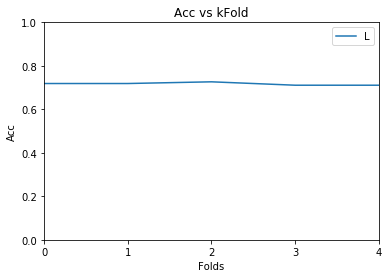

In [31]:
graphic_data([0,1,2,3,4],data,("LSTM w2v50"),'Acc vs kFold', 'Folds', 'Acc',0,0,4,1)

#### Parte Validación: variando valor de units, w2v50, LSTM

In [32]:
acc_final_w2v50 = []
score_final_w2v50 = []
history_final_w2v50 = []
models_w2v50 = []
perform_final_validation(Xw2v50, Yw2v50, X_1w2v50, Y_1w2v50, w2v50_emb_size)
score_final_w2v50,acc_final_w2v50,history_final_w2v50,models_w2v50 = perform_final_validation(Xw2v50, Yw2v50,
                                                                                X_1w2v50, Y_1w2v50, w2v50_emb_size,
                                                                                              units_final,epochs,0)

########################
## UNIT SIZE  8
Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_23 (LSTM)               (None, 8)                 1888      
_________________________________________________________________
dropout_23 (Dropout)         (None, 8)                 0         
_________________________________________________________________
dense_23 (Dense)             (None, 4)                 36        
_________________________________________________________________
activation_23 (Activation)   (None, 4)                 0         
Total params: 1,924
Trainable params: 1,924
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
640/640 [==============================] - 2s 2ms/step - loss: 1.3865 - accuracy: 0.3125
Epoch 2/200
640/640 [==============================] - 0s 509us/step - loss: 1.3743 - accuracy: 0.3719
Epoc

Epoch 71/200
640/640 [==============================] - 0s 374us/step - loss: 0.8229 - accuracy: 0.7219
Epoch 72/200
640/640 [==============================] - 0s 331us/step - loss: 0.7956 - accuracy: 0.7125
Epoch 73/200
640/640 [==============================] - 0s 384us/step - loss: 0.7860 - accuracy: 0.7250
Epoch 74/200
640/640 [==============================] - 0s 669us/step - loss: 0.8230 - accuracy: 0.7125
Epoch 75/200
640/640 [==============================] - 0s 260us/step - loss: 0.7952 - accuracy: 0.7078
Epoch 76/200
640/640 [==============================] - 0s 304us/step - loss: 0.7961 - accuracy: 0.7047
Epoch 77/200
640/640 [==============================] - 0s 354us/step - loss: 0.8022 - accuracy: 0.7063
Epoch 78/200
640/640 [==============================] - 0s 211us/step - loss: 0.7738 - accuracy: 0.7234
Epoch 79/200
640/640 [==============================] - 0s 262us/step - loss: 0.7794 - accuracy: 0.7219
Epoch 80/200
640/640 [==============================] - 0s 322us

640/640 [==============================] - 0s 370us/step - loss: 0.5716 - accuracy: 0.8047
Epoch 150/200
640/640 [==============================] - 0s 309us/step - loss: 0.5647 - accuracy: 0.8156
Epoch 151/200
640/640 [==============================] - 0s 225us/step - loss: 0.5659 - accuracy: 0.8141
Epoch 152/200
640/640 [==============================] - 0s 348us/step - loss: 0.5597 - accuracy: 0.8094
Epoch 153/200
640/640 [==============================] - 0s 308us/step - loss: 0.5350 - accuracy: 0.8219
Epoch 154/200
640/640 [==============================] - 0s 245us/step - loss: 0.5497 - accuracy: 0.8203
Epoch 155/200
640/640 [==============================] - 0s 281us/step - loss: 0.5558 - accuracy: 0.8234
Epoch 156/200
640/640 [==============================] - 0s 233us/step - loss: 0.5285 - accuracy: 0.8219
Epoch 157/200
640/640 [==============================] - 0s 239us/step - loss: 0.5412 - accuracy: 0.8203
Epoch 158/200
640/640 [==============================] - 0s 231us/ste

640/640 [==============================] - 0s 368us/step - loss: 1.1491 - accuracy: 0.5234
Epoch 19/200
640/640 [==============================] - 0s 317us/step - loss: 1.0991 - accuracy: 0.5594
Epoch 20/200
640/640 [==============================] - 0s 321us/step - loss: 1.0733 - accuracy: 0.5594
Epoch 21/200
640/640 [==============================] - 0s 444us/step - loss: 1.0472 - accuracy: 0.5781
Epoch 22/200
640/640 [==============================] - 0s 346us/step - loss: 1.0116 - accuracy: 0.6000
Epoch 23/200
640/640 [==============================] - 0s 402us/step - loss: 0.9902 - accuracy: 0.6047
Epoch 24/200
640/640 [==============================] - 0s 397us/step - loss: 0.9578 - accuracy: 0.5938
Epoch 25/200
640/640 [==============================] - 0s 303us/step - loss: 0.9188 - accuracy: 0.6359
Epoch 26/200
640/640 [==============================] - 0s 379us/step - loss: 0.9133 - accuracy: 0.6156
Epoch 27/200
640/640 [==============================] - 0s 328us/step - loss:

640/640 [==============================] - 0s 350us/step - loss: 0.3834 - accuracy: 0.9031
Epoch 97/200
640/640 [==============================] - 0s 358us/step - loss: 0.3759 - accuracy: 0.9031
Epoch 98/200
640/640 [==============================] - 0s 354us/step - loss: 0.4024 - accuracy: 0.8953
Epoch 99/200
640/640 [==============================] - 0s 431us/step - loss: 0.3863 - accuracy: 0.9047
Epoch 100/200
640/640 [==============================] - 0s 312us/step - loss: 0.3920 - accuracy: 0.9047
Epoch 101/200
640/640 [==============================] - 0s 306us/step - loss: 0.3788 - accuracy: 0.9047
Epoch 102/200
640/640 [==============================] - 0s 337us/step - loss: 0.3665 - accuracy: 0.9125
Epoch 103/200
640/640 [==============================] - 0s 273us/step - loss: 0.3764 - accuracy: 0.9062
Epoch 104/200
640/640 [==============================] - 0s 380us/step - loss: 0.3640 - accuracy: 0.9094
Epoch 105/200
640/640 [==============================] - 0s 334us/step -

640/640 [==============================] - 0s 305us/step - loss: 0.2836 - accuracy: 0.9375
Epoch 175/200
640/640 [==============================] - 0s 364us/step - loss: 0.2725 - accuracy: 0.9391
Epoch 176/200
640/640 [==============================] - 0s 270us/step - loss: 0.2600 - accuracy: 0.9422
Epoch 177/200
640/640 [==============================] - 0s 229us/step - loss: 0.2676 - accuracy: 0.9391
Epoch 178/200
640/640 [==============================] - 0s 248us/step - loss: 0.2669 - accuracy: 0.9406
Epoch 179/200
640/640 [==============================] - 0s 361us/step - loss: 0.2710 - accuracy: 0.9406
Epoch 180/200
640/640 [==============================] - 0s 292us/step - loss: 0.2488 - accuracy: 0.9406
Epoch 181/200
640/640 [==============================] - 0s 351us/step - loss: 0.2592 - accuracy: 0.9391
Epoch 182/200
640/640 [==============================] - 0s 284us/step - loss: 0.2708 - accuracy: 0.9391
Epoch 183/200
640/640 [==============================] - 0s 237us/ste

640/640 [==============================] - 0s 447us/step - loss: 0.4093 - accuracy: 0.8656
Epoch 44/200
640/640 [==============================] - 0s 329us/step - loss: 0.3743 - accuracy: 0.8750
Epoch 45/200
640/640 [==============================] - 0s 536us/step - loss: 0.3626 - accuracy: 0.8797
Epoch 46/200
640/640 [==============================] - 0s 408us/step - loss: 0.3477 - accuracy: 0.8906
Epoch 47/200
640/640 [==============================] - 0s 428us/step - loss: 0.3460 - accuracy: 0.8953
Epoch 48/200
640/640 [==============================] - 0s 387us/step - loss: 0.3327 - accuracy: 0.9062
Epoch 49/200
640/640 [==============================] - 0s 385us/step - loss: 0.3455 - accuracy: 0.9000
Epoch 50/200
640/640 [==============================] - 0s 390us/step - loss: 0.3127 - accuracy: 0.9094
Epoch 51/200
640/640 [==============================] - 0s 366us/step - loss: 0.3326 - accuracy: 0.9031
Epoch 52/200
640/640 [==============================] - 0s 442us/step - loss:

640/640 [==============================] - 0s 612us/step - loss: 0.0916 - accuracy: 0.9766
Epoch 122/200
640/640 [==============================] - 0s 482us/step - loss: 0.1104 - accuracy: 0.9703
Epoch 123/200
640/640 [==============================] - 0s 441us/step - loss: 0.0979 - accuracy: 0.9750
Epoch 124/200
640/640 [==============================] - 0s 437us/step - loss: 0.0945 - accuracy: 0.9734
Epoch 125/200
640/640 [==============================] - 0s 494us/step - loss: 0.1312 - accuracy: 0.9750
Epoch 126/200
640/640 [==============================] - 0s 535us/step - loss: 0.1053 - accuracy: 0.9797
Epoch 127/200
640/640 [==============================] - 0s 615us/step - loss: 0.0922 - accuracy: 0.9750
Epoch 128/200
640/640 [==============================] - 0s 626us/step - loss: 0.1081 - accuracy: 0.9672
Epoch 129/200
640/640 [==============================] - 0s 511us/step - loss: 0.1238 - accuracy: 0.9656
Epoch 130/200
640/640 [==============================] - 0s 552us/ste

640/640 [==============================] - 0s 410us/step - loss: 0.0353 - accuracy: 0.9953
Epoch 200/200
113/113 [==============================] - 1s 7ms/step
########################
## UNIT SIZE  64
Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_26 (LSTM)               (None, 64)                29440     
_________________________________________________________________
dropout_26 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_26 (Dense)             (None, 4)                 260       
_________________________________________________________________
activation_26 (Activation)   (None, 4)                 0         
Total params: 29,700
Trainable params: 29,700
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
640/640 [========================

640/640 [==============================] - 1s 809us/step - loss: 0.0437 - accuracy: 0.9906
Epoch 69/200
640/640 [==============================] - 0s 728us/step - loss: 0.0437 - accuracy: 0.9906
Epoch 70/200
640/640 [==============================] - 0s 659us/step - loss: 0.0453 - accuracy: 0.9937
Epoch 71/200
640/640 [==============================] - 0s 630us/step - loss: 0.0355 - accuracy: 0.9922
Epoch 72/200
640/640 [==============================] - 0s 581us/step - loss: 0.0414 - accuracy: 0.9922
Epoch 73/200
640/640 [==============================] - 0s 548us/step - loss: 0.0403 - accuracy: 0.9937
Epoch 74/200
640/640 [==============================] - 0s 528us/step - loss: 0.0391 - accuracy: 0.9937
Epoch 75/200
640/640 [==============================] - 0s 639us/step - loss: 0.0356 - accuracy: 0.9922
Epoch 76/200
640/640 [==============================] - 0s 721us/step - loss: 0.0846 - accuracy: 0.9828
Epoch 77/200
640/640 [==============================] - 0s 647us/step - loss:

640/640 [==============================] - 0s 696us/step - loss: 0.0054 - accuracy: 0.9984
Epoch 147/200
640/640 [==============================] - 0s 730us/step - loss: 0.0053 - accuracy: 0.9984
Epoch 148/200
640/640 [==============================] - 0s 696us/step - loss: 0.0057 - accuracy: 0.9984
Epoch 149/200
640/640 [==============================] - 0s 727us/step - loss: 0.0047 - accuracy: 0.9984
Epoch 150/200
640/640 [==============================] - 0s 708us/step - loss: 0.0039 - accuracy: 1.0000
Epoch 151/200
640/640 [==============================] - 0s 702us/step - loss: 0.0042 - accuracy: 0.9984
Epoch 152/200
640/640 [==============================] - 1s 783us/step - loss: 0.0038 - accuracy: 1.0000
Epoch 153/200
640/640 [==============================] - 0s 686us/step - loss: 0.0051 - accuracy: 0.9984
Epoch 154/200
640/640 [==============================] - 0s 662us/step - loss: 0.0043 - accuracy: 1.0000
Epoch 155/200
640/640 [==============================] - 0s 642us/ste

640/640 [==============================] - 1s 1ms/step - loss: 0.4130 - accuracy: 0.8578
Epoch 16/200
640/640 [==============================] - 1s 977us/step - loss: 0.3791 - accuracy: 0.8813
Epoch 17/200
640/640 [==============================] - 1s 834us/step - loss: 0.3410 - accuracy: 0.8828
Epoch 18/200
640/640 [==============================] - 1s 858us/step - loss: 0.3143 - accuracy: 0.8984
Epoch 19/200
640/640 [==============================] - 1s 1ms/step - loss: 0.2842 - accuracy: 0.9141
Epoch 20/200
640/640 [==============================] - 1s 937us/step - loss: 0.2608 - accuracy: 0.9109
Epoch 21/200
640/640 [==============================] - 1s 999us/step - loss: 0.2268 - accuracy: 0.9375
Epoch 22/200
640/640 [==============================] - 1s 917us/step - loss: 0.2061 - accuracy: 0.9375
Epoch 23/200
640/640 [==============================] - 1s 1ms/step - loss: 0.1991 - accuracy: 0.9391
Epoch 24/200
640/640 [==============================] - 1s 895us/step - loss: 0.202

640/640 [==============================] - 1s 1ms/step - loss: 0.0096 - accuracy: 0.9984
Epoch 95/200
640/640 [==============================] - 1s 1ms/step - loss: 0.0099 - accuracy: 0.9984
Epoch 96/200
640/640 [==============================] - 1s 989us/step - loss: 0.0087 - accuracy: 0.9984
Epoch 97/200
640/640 [==============================] - 1s 1ms/step - loss: 0.0110 - accuracy: 0.9984
Epoch 98/200
640/640 [==============================] - 1s 2ms/step - loss: 0.0106 - accuracy: 0.9984
Epoch 99/200
640/640 [==============================] - 1s 2ms/step - loss: 0.0096 - accuracy: 0.9984
Epoch 100/200
640/640 [==============================] - 1s 1ms/step - loss: 0.0094 - accuracy: 0.9984
Epoch 101/200
640/640 [==============================] - 1s 1ms/step - loss: 0.0098 - accuracy: 0.9984
Epoch 102/200
640/640 [==============================] - 1s 1ms/step - loss: 0.0068 - accuracy: 0.9984
Epoch 103/200
640/640 [==============================] - 1s 1ms/step - loss: 0.0106 - accu

640/640 [==============================] - 1s 1ms/step - loss: 3.7596e-04 - accuracy: 1.0000
Epoch 173/200
640/640 [==============================] - 1s 1ms/step - loss: 3.7899e-04 - accuracy: 1.0000
Epoch 174/200
640/640 [==============================] - 1s 1ms/step - loss: 3.6056e-04 - accuracy: 1.0000
Epoch 175/200
640/640 [==============================] - 1s 1ms/step - loss: 4.1503e-04 - accuracy: 1.0000
Epoch 176/200
640/640 [==============================] - 1s 1ms/step - loss: 3.9061e-04 - accuracy: 1.0000
Epoch 177/200
640/640 [==============================] - 1s 1ms/step - loss: 3.7364e-04 - accuracy: 1.0000
Epoch 178/200
640/640 [==============================] - 1s 1ms/step - loss: 3.6417e-04 - accuracy: 1.0000
Epoch 179/200
640/640 [==============================] - 1s 1ms/step - loss: 3.2965e-04 - accuracy: 1.0000
Epoch 180/200
640/640 [==============================] - 1s 1ms/step - loss: 3.4907e-04 - accuracy: 1.0000
Epoch 181/200
640/640 [============================

640/640 [==============================] - 1s 2ms/step - loss: 0.1033 - accuracy: 0.9812
Epoch 42/200
640/640 [==============================] - 1s 2ms/step - loss: 0.0590 - accuracy: 0.9859
Epoch 43/200
640/640 [==============================] - 1s 2ms/step - loss: 0.0565 - accuracy: 0.9844
Epoch 44/200
640/640 [==============================] - 1s 2ms/step - loss: 0.0817 - accuracy: 0.9750
Epoch 45/200
640/640 [==============================] - 1s 2ms/step - loss: 0.0788 - accuracy: 0.9797
Epoch 46/200
640/640 [==============================] - 1s 2ms/step - loss: 0.1180 - accuracy: 0.9703
Epoch 47/200
640/640 [==============================] - 1s 2ms/step - loss: 0.0800 - accuracy: 0.9781
Epoch 48/200
640/640 [==============================] - 1s 2ms/step - loss: 0.0941 - accuracy: 0.9750
Epoch 49/200
640/640 [==============================] - 1s 2ms/step - loss: 0.0725 - accuracy: 0.9797
Epoch 50/200
640/640 [==============================] - 1s 2ms/step - loss: 0.0445 - accuracy: 

640/640 [==============================] - 1s 2ms/step - loss: 4.6279e-04 - accuracy: 1.0000
Epoch 121/200
640/640 [==============================] - 1s 2ms/step - loss: 4.3329e-04 - accuracy: 1.0000
Epoch 122/200
640/640 [==============================] - 1s 2ms/step - loss: 4.1525e-04 - accuracy: 1.0000
Epoch 123/200
640/640 [==============================] - 1s 2ms/step - loss: 4.6585e-04 - accuracy: 1.0000
Epoch 124/200
640/640 [==============================] - 1s 2ms/step - loss: 3.9042e-04 - accuracy: 1.0000
Epoch 125/200
640/640 [==============================] - 1s 2ms/step - loss: 3.8565e-04 - accuracy: 1.0000
Epoch 126/200
640/640 [==============================] - 1s 2ms/step - loss: 4.8829e-04 - accuracy: 1.0000
Epoch 127/200
640/640 [==============================] - 1s 2ms/step - loss: 3.6360e-04 - accuracy: 1.0000
Epoch 128/200
640/640 [==============================] - 1s 2ms/step - loss: 3.5251e-04 - accuracy: 1.0000
Epoch 129/200
640/640 [============================

640/640 [==============================] - 1s 2ms/step - loss: 1.7368e-04 - accuracy: 1.0000
Epoch 197/200
640/640 [==============================] - 1s 2ms/step - loss: 1.4605e-04 - accuracy: 1.0000
Epoch 198/200
640/640 [==============================] - 1s 2ms/step - loss: 1.4560e-04 - accuracy: 1.0000
Epoch 199/200
640/640 [==============================] - 1s 2ms/step - loss: 1.5752e-04 - accuracy: 1.0000
Epoch 200/200
113/113 [==============================] - 1s 8ms/step
########################
## UNIT SIZE  128
Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_29 (LSTM)               (None, 128)               91648     
_________________________________________________________________
dropout_29 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_29 (Dense)             (None, 4)                 

#### Parte  Gráficos: variando valor de units, w2v50, LSTM

In [33]:
#Preparando los datos para graficar
data_final_acc_w2v50 = []
data_final_loss_w2v50 = []


for i in np.arange(0,len(units_final)):
    data_final_acc_w2v50.append(history_final_w2v50[i].history['accuracy'])

for i in np.arange(0,len(units_final)):
    data_final_loss_w2v50.append(history_final_w2v50[i].history['loss'])
   

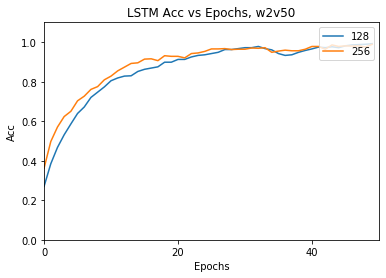

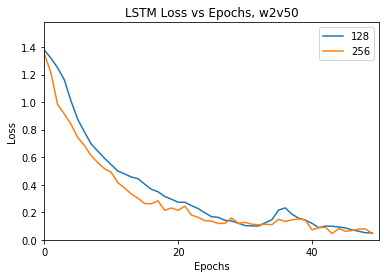

In [34]:
##Gráfico de Accuracy
graphic_data(np.arange(0,epochs,20),data_final_acc_w2v50,units_final,'LSTM Acc vs Epochs, w2v50', 'Epochs', 'Acc',0,0,epochs,1+0.1)

##Gráfico de Loss 
max_loss_w2v50 = 0
for i in np.arange(0,len(data_final_loss_w2v50)):
    if(max(data_final_loss_w2v50[i]) > max_loss_w2v50):
        max_loss_w2v50 = max(data_final_loss_w2v50[i])
graphic_data(np.arange(0,epochs,20),data_final_loss_w2v50,units_final,'LSTM Loss vs Epochs, w2v50', 'Epochs', 'Loss',
             0,0,epochs,max_loss_w2v50+0.2)

### Predicción: Modelo w2v50, LSTM

In [35]:
def predict_all_models(X_real, Y_real, models):
    j = 0
    all_predict = []
    counter_true =  collections.Counter(Y_real.argmax(1))
    for i in units_final:
        print("##### Predict, Units ", i,"#####")
        Y_predict_i=models[j].predict(X_real)
        counter_pred_i = collections.Counter(Y_predict_i.argmax(1))
        all_predict.append(Y_predict_i)
        print("predict: ",list(counter_pred_i.values()))
        print("Real   : ",list(counter_true.values()))
        j = j + 1
    return all_predict

In [36]:
all_predict_w2v50 = []
all_predict_w2v50 = predict_all_models(Xw2v50_full,Yw2v50_full,models_w2v50)

##### Predict, Units  128 #####
predict:  [190, 177, 182, 204]
Real   :  [188, 180, 180, 205]
##### Predict, Units  256 #####
predict:  [189, 177, 180, 207]
Real   :  [188, 180, 180, 205]


In [37]:
i = 0
for j in units_final:
    print("Units:", j, " - RMSE LSTM w2v50:  ",mean_squared_error(Yw2v50_full, all_predict_w2v50[i])) #Y_true, Y_predict
    i = i + 1

Units: 128  - RMSE LSTM w2v50:   0.022268333
Units: 256  - RMSE LSTM w2v50:   0.019020608


#### Matriz Confusión: w2v50

Confusion matrix, without normalization
Confusion matrix, without normalization


<Figure size 360x360 with 0 Axes>

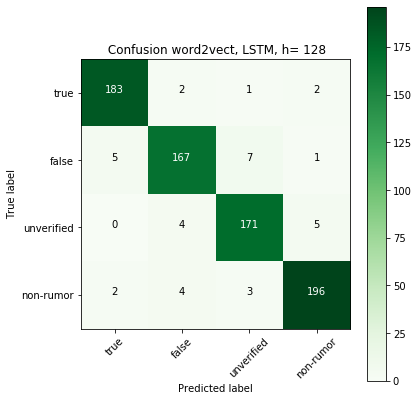

<Figure size 360x360 with 0 Axes>

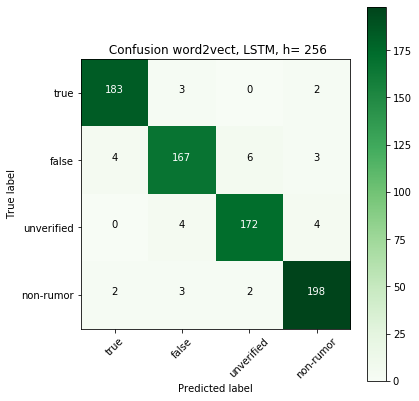

In [38]:
j = 0
for i in units_final:
    plot_conf_matrix(Yw2v50_full, all_predict_w2v50[j]," Confusion word2vect, LSTM, h= " + str(i))
    j = j +1

In [ ]:
print(Yw2v50_full)